Using device: cpu


c:\Users\vmura\anaconda3\envs\new_en\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vmura\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model expects 224x224 images.
Classes: ['1_Good', '2_Moderate', '3_Unhealthy_For_Sensitive_Groups', '4_Unhealthy', '5_Very_Unhealthy']


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for 10 epochs...
------------------------------
Epoch 1/10
Training Loss: 1.1032
Validation Loss: 0.6172
  Accuracy: 83.05%
  Precision (Weighted): 0.8478
  Recall (Weighted): 0.8305
  F1-Score (Weighted): 0.8315
------------------------------
Epoch 2/10
Training Loss: 0.3960
Validation Loss: 0.2735
  Accuracy: 94.92%
  Precision (Weighted): 0.9506
  Recall (Weighted): 0.9492
  F1-Score (Weighted): 0.9496
------------------------------
Epoch 3/10
Training Loss: 0.1889
Validation Loss: 0.1398
  Accuracy: 98.87%
  Precision (Weighted): 0.9889
  Recall (Weighted): 0.9887
  F1-Score (Weighted): 0.9887
------------------------------
Epoch 4/10
Training Loss: 0.1006
Validation Loss: 0.0807
  Accuracy: 98.31%
  Precision (Weighted): 0.9842
  Recall (Weighted): 0.9831
  F1-Score (Weighted): 0.9831
------------------------------
Epoch 5/10
Training Loss: 0.0567
Validation Loss: 0.0584
  Accuracy: 98.87%
  Precision (Weighted): 0.9889
  Recall (Weighted): 0.9887
  F1-Score (Wei

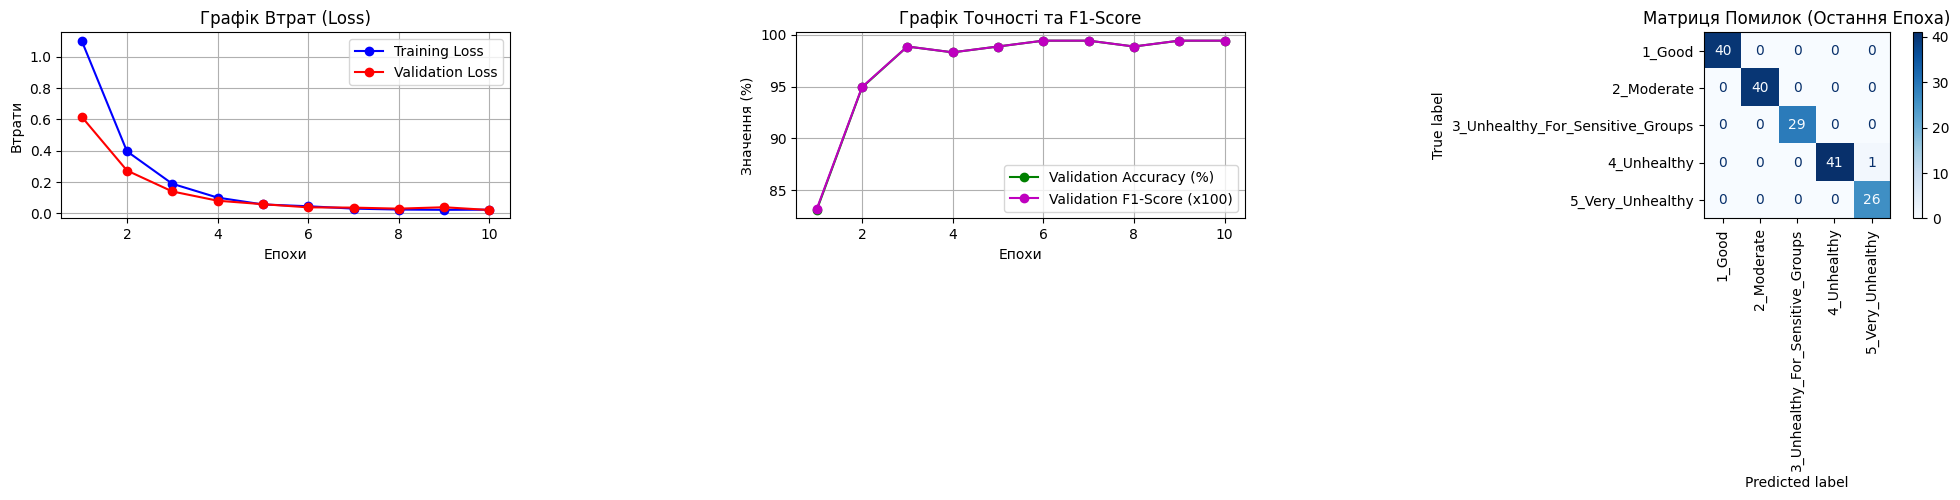

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


DATA_PATH_TRAIN = 'dataSet/train'
DATA_PATH_VAL = 'dataSet/val'
SAVE_PATH = 'models/vit_air_quality_model.pth' 

MODEL_NAME = 'google/vit-base-patch16-224'
NUM_LABELS = 5 


BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 10           


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
image_mean = processor.image_mean
image_std = processor.image_std
image_size = processor.size['height']

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

train_dataset = datasets.ImageFolder(DATA_PATH_TRAIN, transform=train_transforms)
val_dataset = datasets.ImageFolder(DATA_PATH_VAL, transform=val_transforms)



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

class_names = train_dataset.classes
print(f"Classes: {class_names}")


model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []
val_accuracy_history = []
val_precision_history = []
val_recall_history = []
val_f1_history = []

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    print("-" * 30)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs.logits, labels)     
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_loss_history.append(epoch_train_loss)
    print(f"Training Loss: {epoch_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    all_labels = [] 
    all_preds = []  

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.logits, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_val_loss = val_loss / len(val_dataset)
    

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, 
        all_preds, 
        average='weighted',
        zero_division=0 
    )
    
    correct = (np.array(all_preds) == np.array(all_labels)).sum()
    accuracy = 100 * correct / len(all_labels)

    
    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(accuracy)
    val_precision_history.append(precision)
    val_recall_history.append(recall)
    val_f1_history.append(f1)

    print(f"Validation Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision (Weighted): {precision:.4f}")
    print(f"  Recall (Weighted): {recall:.4f}")
    print(f"  F1-Score (Weighted): {f1:.4f}")

print("Training finished.")

torch.save(model.state_dict(), SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")


epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_history, 'b-o', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'r-o', label='Validation Loss')
plt.title('Графік Втрат (Loss)')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)



plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_accuracy_history, 'g-o', label='Validation Accuracy (%)')
plt.plot(epochs_range, [f * 100 for f in val_f1_history], 'm-o', label='Validation F1-Score (x100)')
plt.title('Графік Точності та F1-Score')
plt.xlabel('Епохи')
plt.ylabel('Значення (%)')
plt.legend()
plt.grid(True)


plt.tight_layout() 
plt.savefig('training_plots.png')
print("Plots saved to training_plots.png")



Generating plots...
Plots saved to training_plots.png


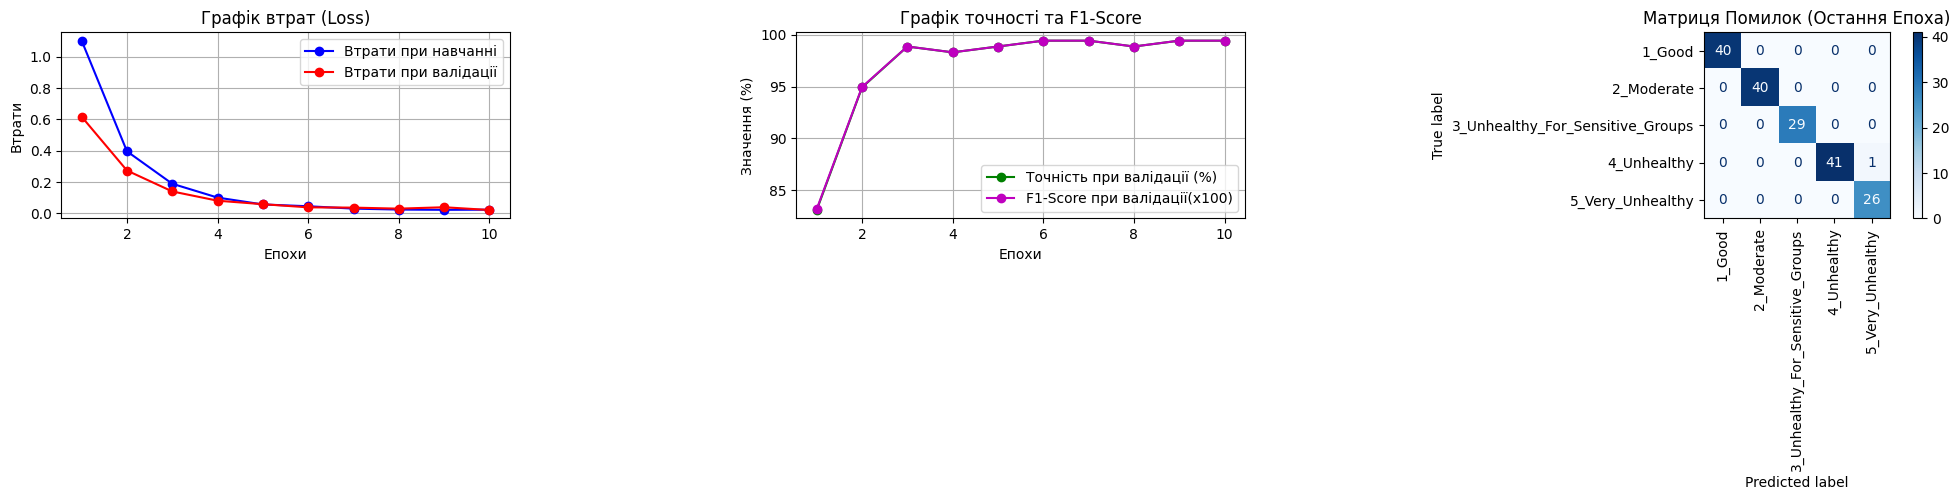

In [ ]:

print("Generating plots...")


epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(20, 5))


plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_history, 'b-o', label='Втрати при навчанні')
plt.plot(epochs_range, val_loss_history, 'r-o', label='Втрати при валідації')
plt.title('Графік втрат (Loss)')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)



plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_accuracy_history, 'g-o', label='Точність при валідації (%)')
plt.plot(epochs_range, [f * 100 for f in val_f1_history], 'm-o', label='F1-Score при валідації(x100)')
plt.title('Графік точності та F1-Score')
plt.xlabel('Епохи')
plt.ylabel('Значення (%)')
plt.legend()
plt.grid(True)



cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)


ax = plt.subplot(1, 3, 3)
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
ax.set_title('Матриця Помилок (Остання Епоха)')


plt.tight_layout() 
plt.savefig('training_plots__.png') 
print("Plots saved to training_plots.png")
